Imports

In [2]:
#import 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm

%matplotlib inline

Get data into df

In [3]:
df = pd.read_csv('./data/kc_house_data.csv',
                parse_dates=['date'])

In [4]:
pd.set_option('display.max_colwidth', None) #allows us to see the full text of each object column, namely the "address" field
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington 98055, United States",47.461975,-122.19052
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washington 98133, United States",47.711525,-122.35591
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 98178, United States",47.502045,-122.22520
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington 98118, United States",47.566110,-122.29020
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washington 98027, United States",47.532470,-122.07188


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

#### Prices

Text(0, 0.5, 'Number of houses')

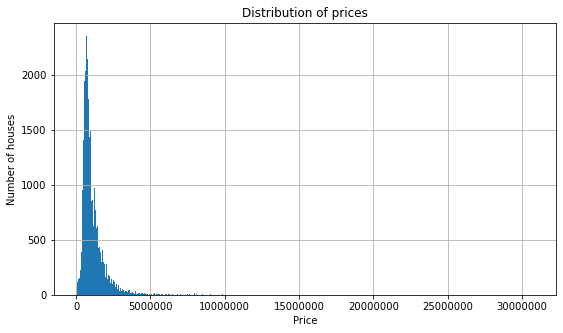

In [6]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df['price'].hist(bins=500, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses')


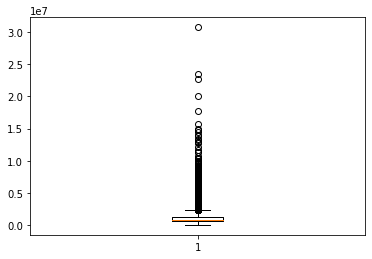

In [7]:
plt.boxplot(df['price']);

The prices appear to be fairly normally distributed, but with a long maximum tail.
Could look at as log, but will instead chop off houses with prices above 5mil, as
"our stakeholders aren't looking to spend that much money". Will chop off above 3*std and re-examine.

In [8]:
df['price'].describe()

count    3.015500e+04
mean     1.108536e+06
std      8.963857e+05
min      2.736000e+04
25%      6.480000e+05
50%      8.600000e+05
75%      1.300000e+06
max      3.075000e+07
Name: price, dtype: float64

In [9]:
df_clean = df.loc[df['price']<5000000]

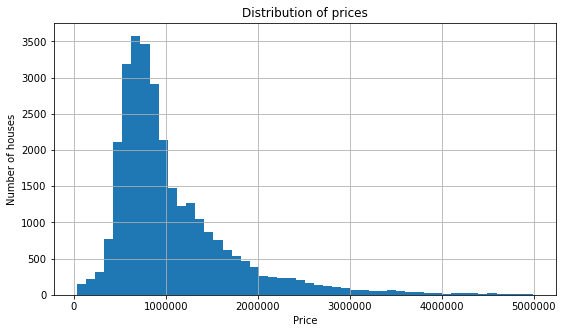

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df_clean['price'].hist(bins=50, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

In [11]:
df_clean['price'].describe()

count    2.994000e+04
mean     1.062370e+06
std      6.572221e+05
min      2.736000e+04
25%      6.450000e+05
50%      8.575000e+05
75%      1.299962e+06
max      4.995000e+06
Name: price, dtype: float64

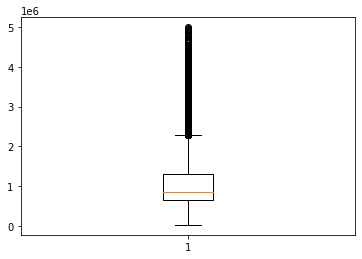

In [12]:
plt.boxplot(df_clean['price']);

Even after chopping off prices above 5mil, there are still a lot of outliers, as defined by the IQR. We will remove these outliers and then re-examine.

In [13]:
# IQR
Q1 = np.percentile(df_clean['price'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(df_clean['price'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1

In [14]:
# Upper bound
upper_limit = Q3 + 1.5 * IQR
upper_limit

2282436.25

According to IQR, which we're using here since the dataset is skewed, values above 2.28 mil are outliers. We'll trim these off.

In [15]:
# Trim
df_clean = df_clean[df_clean['price'] < upper_limit]

Now that we have trimmed off these outliers, we'll re-examine the dataset.

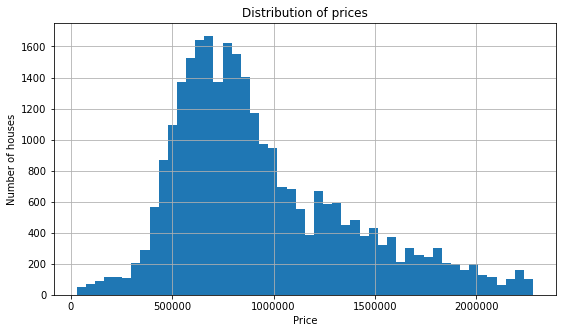

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df_clean['price'].hist(bins=50, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

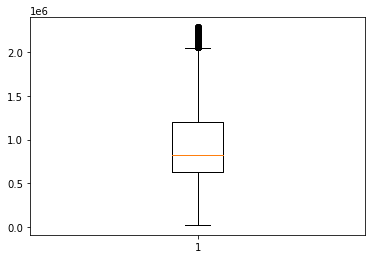

In [17]:
plt.boxplot(df_clean['price']);

In [18]:
df_clean['price'].describe()

count    2.816500e+04
mean     9.417486e+05
std      4.351478e+05
min      2.736000e+04
25%      6.300000e+05
50%      8.299500e+05
75%      1.199000e+06
max      2.281000e+06
Name: price, dtype: float64

In [19]:
stats.skewtest(df_clean['price'], axis=0, nan_policy='raise')

SkewtestResult(statistic=53.48353519446607, pvalue=0.0)

After some additional research, it looks like the independent and dependent variables don't need to have a good normal distribution to work on, only the errors need to be normally distributed. With this in mind we can go ahead to the next variable.

In [20]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28165 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             28165 non-null  int64         
 1   date           28165 non-null  datetime64[ns]
 2   price          28165 non-null  float64       
 3   bedrooms       28165 non-null  int64         
 4   bathrooms      28165 non-null  float64       
 5   sqft_living    28165 non-null  int64         
 6   sqft_lot       28165 non-null  int64         
 7   floors         28165 non-null  float64       
 8   waterfront     28165 non-null  object        
 9   greenbelt      28165 non-null  object        
 10  nuisance       28165 non-null  object        
 11  view           28165 non-null  object        
 12  condition      28165 non-null  object        
 13  grade          28165 non-null  object        
 14  heat_source    28134 non-null  object        
 15  sewer_system   2815

In [21]:
df_clean['bedrooms'].value_counts()

3     12422
4      8735
2      3886
5      2215
6       384
1       371
7        62
0        40
8        33
9        13
10        3
11        1
Name: bedrooms, dtype: int64

0 bedroom = studio
11 bedroom?? sure I guess. These seem ok.

In [22]:
df_clean['bathrooms'].value_counts()

2.5    8175
2.0    7237
1.0    4527
3.0    3836
1.5    1784
3.5    1776
4.0     464
4.5     216
5.0      52
5.5      31
0.0      30
6.0      19
6.5       5
0.5       5
7.0       4
7.5       4
Name: bathrooms, dtype: int64

There is no way these homes have 0 bathrooms. Changing the 0's to 1's. Rounding 0.5's up as these are quasi-categorical.(2x 0.5bath != 1bath. 1x 1bath = 2bath.)

In [23]:
df_clean.loc[df_clean['bathrooms'] == 0, 'bathrooms'] = 1
df_clean['bathrooms'] = df_clean['bathrooms'].apply(np.ceil)

Drop unnecessary columns:

In [24]:
df_clean.drop(['id', 'date', 'sqft_lot', 'floors'], axis=1, inplace=True)

In [25]:
df_clean['bathrooms'].value_counts()

3.0    12011
2.0     9021
1.0     4562
4.0     2240
5.0      268
6.0       50
7.0        9
8.0        4
Name: bathrooms, dtype: int64

Try log of price again, to see if it looks more normal.

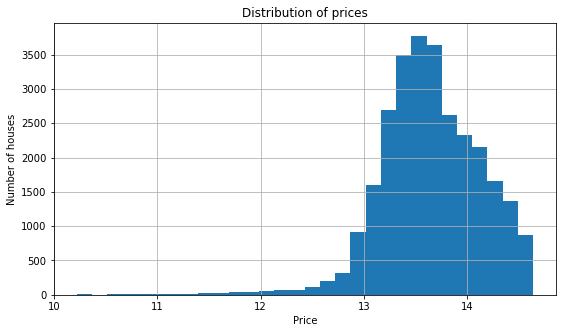

In [26]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
np.log(df_clean['price']).hist(bins=30, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

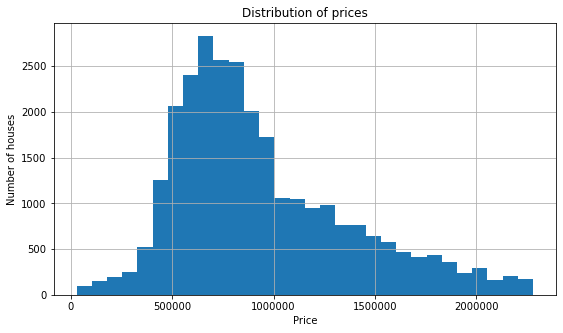

In [28]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))
df_clean['price'].hist(bins=30, ax=ax)
ax.ticklabel_format(style='plain')
plt.xlabel('Price')
plt.title('Distribution of prices')
plt.ylabel('Number of houses');

In [29]:
df_clean['view'].value_counts()

NONE         25359
AVERAGE       1670
GOOD           681
EXCELLENT      279
FAIR           176
Name: view, dtype: int64